<h1 align = 'center'> Hamza Salah </h1>
<h2 align = 'center'> DSC 680: Applied Data Science </h2>
<h2 align = 'center'> Project 1: Retail Demand Forecast</h2>

### Import Libraries & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = r'retail_data.csv'
df = pd.read_csv(data)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year.astype(str)
df['Month'] = df['Date'].dt.month.astype(str)
df['Year_Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')

In [29]:
df.head(3)

,Product_ID,Product_Name,Category,Promotion_Flag,Sales_Volume,Year,Month,Year_Month,Sales_Volume_Scaled,Promotion_Flag_Scaled
Date,,,,,,,,,,
2022-01-01,SW-F-B-S-01,Women's Floral Bikini,Apparel,0,12,2022,1,2022-01-01,-0.221822,-0.434815
2022-01-01,TS-U-PLAIN-M-01,Unisex Plain T-Shirt,Apparel,0,8,2022,1,2022-01-01,-0.674414,-0.434815
2022-01-01,PUZZLE-JIGSAW-1K,1000 Piece Jigsaw Puzzle,Toys,0,16,2022,1,2022-01-01,0.230770,-0.434815


### Summary Stats

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16440 entries, 0 to 16439
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            16440 non-null  datetime64[ns]
 1   Product_ID      16440 non-null  object        
 2   Product_Name    16440 non-null  object        
 3   Category        16440 non-null  object        
 4   Promotion_Flag  16440 non-null  int64         
 5   Sales_Volume    16440 non-null  int64         
 6   Year            16440 non-null  object        
 7   Month           16440 non-null  object        
 8   Year_Month      16440 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 1.1+ MB


I have a total of  16440 rows, and 6 columns.

In [8]:
df.describe()

,Date,Promotion_Flag,Sales_Volume,Year_Month
count,16440,16440.000000,16440.000000,16440
mean,2023-07-02 12:00:00,0.159002,13.960462,2023-06-17 18:24:57.810219008
min,2022-01-01 00:00:00,0.000000,1.000000,2022-01-01 00:00:00
25%,2022-10-01 18:00:00,0.000000,8.000000,2022-10-01 00:00:00
50%,2023-07-02 12:00:00,0.000000,13.000000,2023-07-01 00:00:00
75%,2024-04-01 06:00:00,0.000000,17.000000,2024-04-01 00:00:00
max,2024-12-31 00:00:00,1.000000,114.000000,2024-12-01 00:00:00
std,NaN,0.365689,8.838255,NaN


The Min Sales volume is 1 unit with 50 and Max sales volume is 114 Units

In [9]:
# c
df.isna().sum()

Date              0
Product_ID        0
Product_Name      0
Category          0
Promotion_Flag    0
Sales_Volume      0
Year              0
Month             0
Year_Month        0
dtype: int64

### EDA

In [10]:
df[['Category', 'Product_ID','Product_Name']].drop_duplicates().reset_index(drop=True)

,Category,Product_ID,Product_Name
0,Apparel,SW-F-B-S-01,Women's Floral Bikini
1,Apparel,JK-M-P-L-01,Men's Puffer Jacket
2,Apparel,TS-U-PLAIN-M-01,Unisex Plain T-Shirt
3,Apparel,JE-W-DNM-SLIM-01,Women's Slim Fit Jeans
4,Apparel,SD-C-LEATHER-01,Classic Leather Sandals
5,Electronics,TV-4K-65IN-SMART-01,65-inch 4K Smart TV
6,Electronics,AC-WIN-10K-01,"10,000 BTU Window AC Unit"
7,Electronics,PH-MOB-SAMSUNG-01,Samsung Galaxy S23 Smartphone
8,Electronics,LP-GAMING-HP-01,HP Omen Gaming Laptop
9,Electronics,SP-BT-NOISE-CAN-01,Bose Noise Cancelling Headphones


There is 3 categories in the dataset, for each category there is 5 unique product ids, a total of 15 products in 3 different categories.

#### Histogram, total products sold all time

<Axes: xlabel='Sales_Volume', ylabel='Count'>

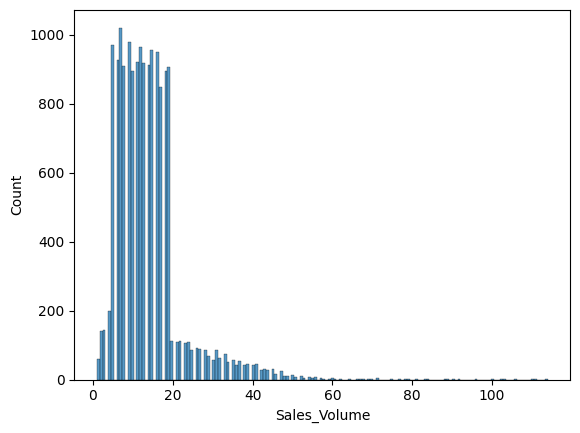

In [11]:
sns.histplot(df['Sales_Volume'])

The histogram shows a right-skewed distribution. This means the majority of the data points are concentrated on the left side of the graph, with a long "tail" extending to the right.

In [12]:
df[['Promotion_Flag','Sales_Volume']].corr()

,Promotion_Flag,Sales_Volume
Promotion_Flag,1.000000,0.395326
Sales_Volume,0.395326,1.000000


There is a 40 percent correlation between promotions and sales.

#### Pivot Tables

I decided to use a pivot table, as it is a form of data visualization that efficiently summarizes and displays data. It showcases different categories and subcategories in a tabular format, making this dataset easier to understand.

In [13]:
pd.pivot_table(df, values= 'Sales_Volume', index =['Category'], columns = ['Year'], aggfunc = 'sum')

Year,2022,2023,2024
Category,,,
Apparel,24993,25511,24828
Electronics,24783,25099,24468
Toys,26298,26528,27002


- Apparel sales volume was 24,993 in 2022, increased to 25,511 in 2023, and then decreased to 24,828 in 2024.

- Electronics sales volume were 24,783 in 2022, increased to 25,099 in 2023, and then decreased to 24,468 in 2024.

- Toys sales volume steadily increased from 26,298 in 2022 to 26,528 in 2023 and reached 27,002 in 2024.

*Further investigating I will perfrom a pivot table to view in depth sales for each product.*

In [14]:
pd.pivot_table(df, values= 'Sales_Volume', index =['Category', 'Product_ID'], columns = ['Year'], aggfunc = 'sum')

Year                             2022  2023  2024
Category    Product_ID                           
Apparel     JE-W-DNM-SLIM-01     4586  4606  4831
            JK-M-P-L-01          4253  4863  4503
            SD-C-LEATHER-01      5695  5626  5557
            SW-F-B-S-01          5876  5738  5373
            TS-U-PLAIN-M-01      4583  4678  4564
Electronics AC-WIN-10K-01        4243  4326  3959
            LP-GAMING-HP-01      5443  5698  5295
            PH-MOB-SAMSUNG-01    4650  4471  4555
            SP-BT-NOISE-CAN-01   4496  4604  4584
            TV-4K-65IN-SMART-01  5951  6000  6075
Toys        AF-H-MARVEL-01       6258  6311  6343
            BO-BUILD-LEGO-01     5488  5743  5626
            DOLL-PRINCESS-01     5672  5536  5477
            PUZZLE-JIGSAW-1K     4398  4589  4770
            WT-BLAST-LG-01       4482  4349  4786

 In the Apparel category, sales trends varied, with some products like JE-W-DNM-SLIM-01 showing steady growth, while others like SD-C-LEATHER-01 declined. Electronics also had mixed results; some products like TV-4K-65IN-SMART-01 and LP-GAMING-HP-01 were top performers with either steady growth or high sales numbers, while others like PH-MOB-SAMSUNG-01 saw a decrease. The Toys category had the most consistent performance, with AF-H-MARVEL-01 and PUZZLE-JIGSAW-1K showing reliable year-over-year growth. Overall, the data reveals a mix of strong, declining, and fluctuating sales across all three categories.

### Sales Analysis

Sales Analysis will be prefomed on each category and product for the 3 years, showing trends over time.

I am thinking of:



Line Charts to identify trends over time.
1. Sales by Category from 2022-2023
2. For each category product sales from 2022-2023


In [15]:
## Sales Analysis
df.head(1)


,Date,Product_ID,Product_Name,Category,Promotion_Flag,Sales_Volume,Year,Month,Year_Month
0,2022-01-01,SW-F-B-S-01,Women's Floral Bikini,Apparel,0,12,2022,1,2022-01-01


Sales by category over time. I need sum of sales by month and then over time.

In [16]:
by_month = df.groupby(['Category', 'Year_Month'])
sum_by_month = by_month['Sales_Volume'].sum().reset_index()

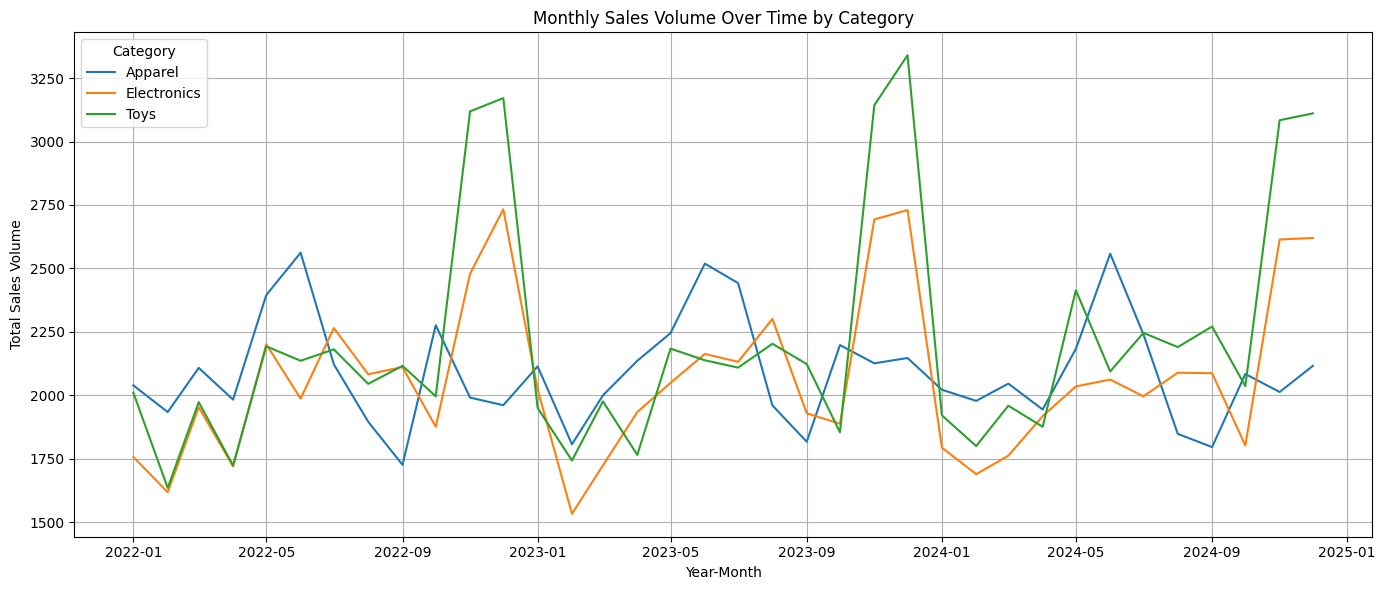

In [17]:
# Create the line plot
plt.figure(figsize=(14, 6)) # Optional: adjusts plot size

sns.lineplot(sum_by_month, x = sum_by_month['Year_Month'], y = sum_by_month['Sales_Volume'], hue='Category')


plt.title('Monthly Sales Volume Over Time by Category')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

The charts reveal distinct seasonal sales patterns for each product category. While Electronics and Toys both experience a significant sales peak in the 4th quarter, driven by holiday shopping, the Apparel category's sales are primarily influenced by summer seasonality, with its highest sales volume occurring in the spring and summer months. This analysis confirms that a single forecasting model would likely fail to capture these unique trends, highlighting the need for tailored strategies based on each category's specific demand drivers.

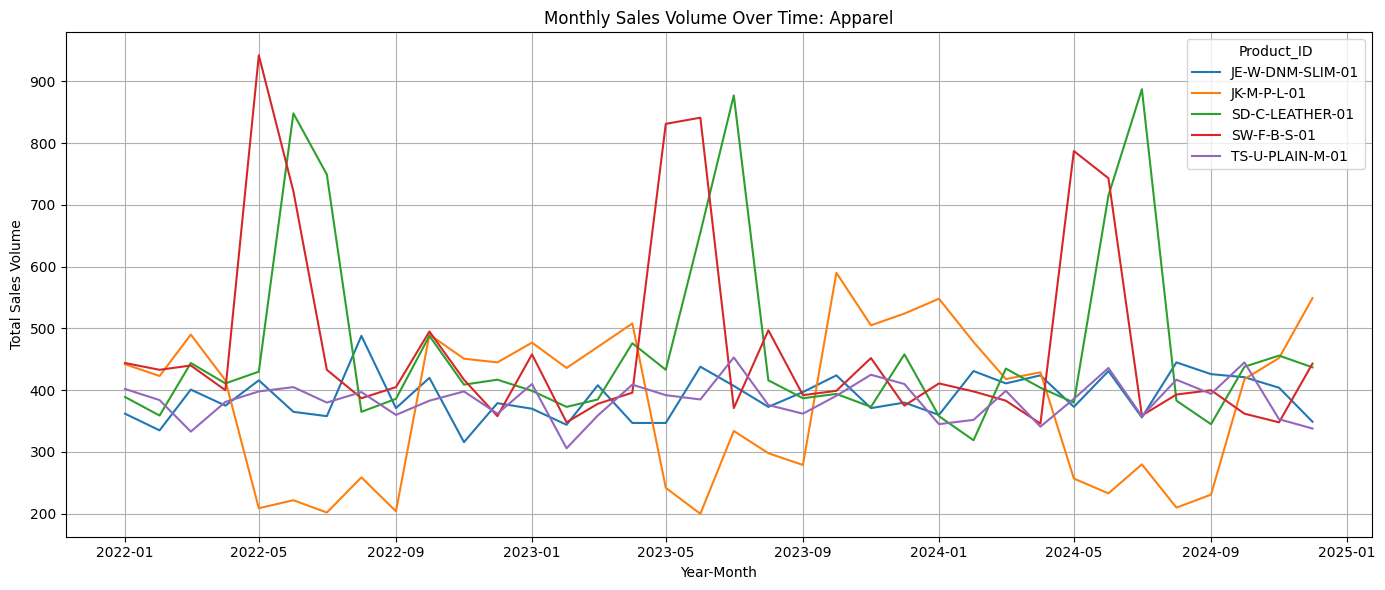

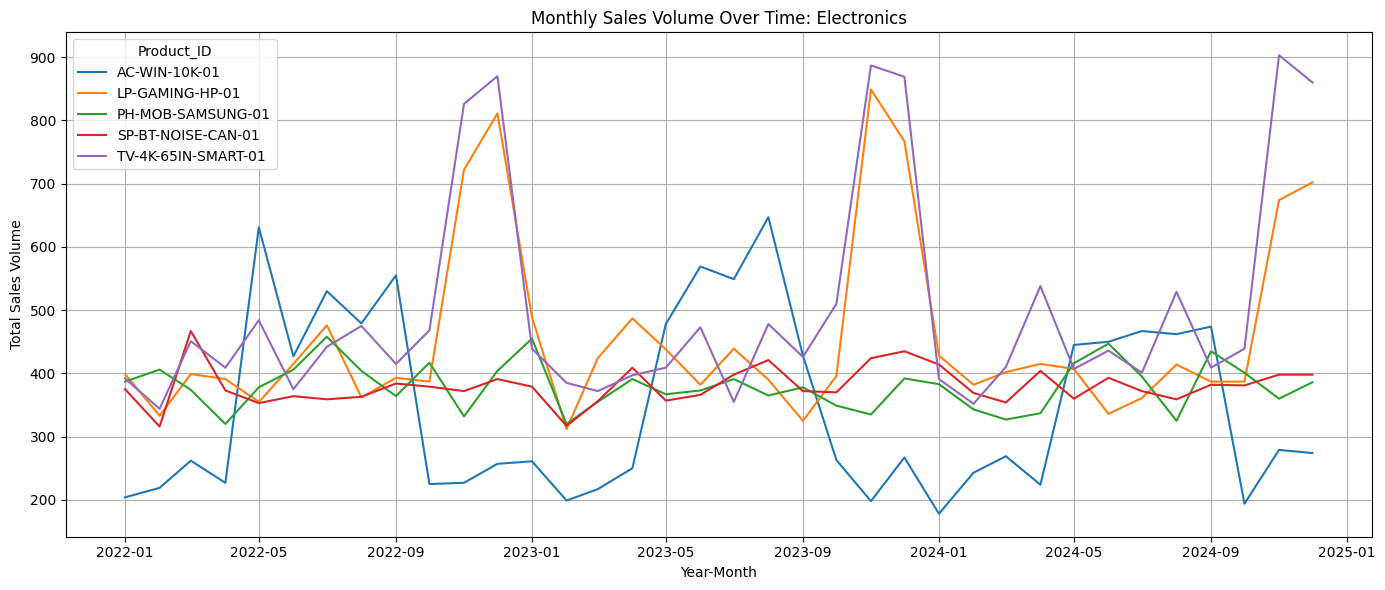

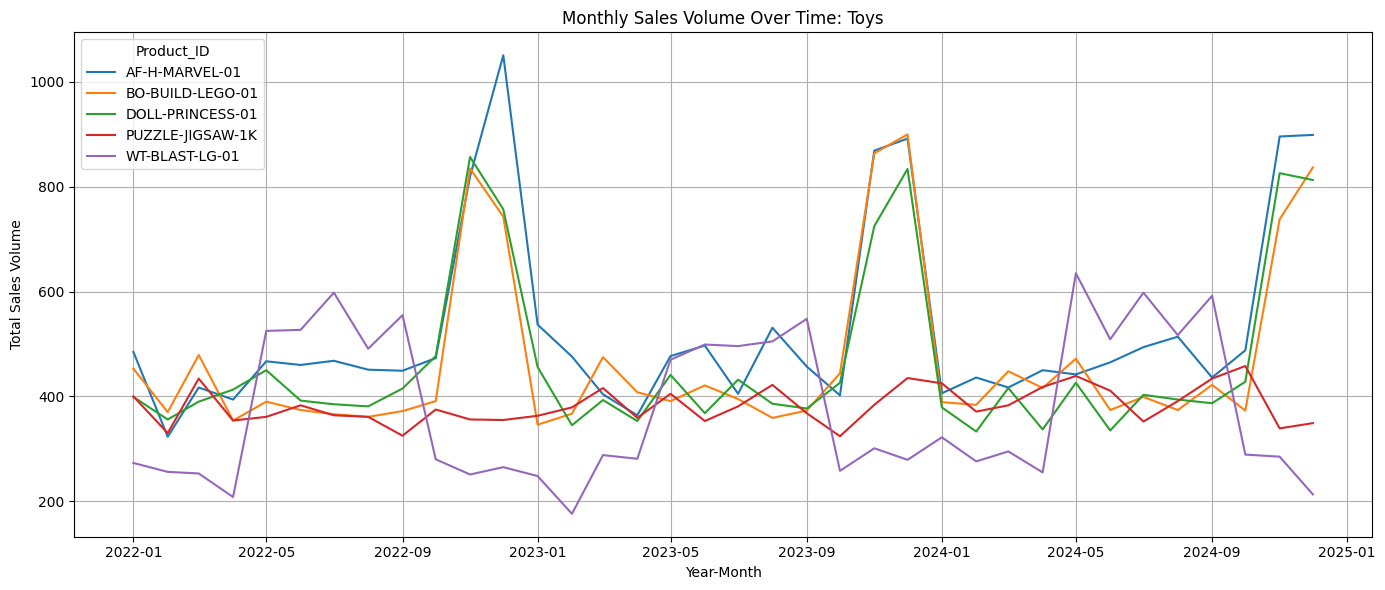

In [18]:
categories = ["Apparel", 'Electronics', "Toys"]

for category in categories:
    df_cat = df[df['Category'] == category]
    by_month_category = df_cat.groupby(['Product_ID', 'Year_Month'])
    sum_by_month_category= by_month_category['Sales_Volume'].sum().reset_index()
    
    # Create the line plot
    plt.figure(figsize=(14, 6)) # Optional: adjusts plot size

    sns.lineplot(sum_by_month_category, x = sum_by_month_category['Year_Month'], y = sum_by_month_category['Sales_Volume'], hue='Product_ID')


    plt.title(f'Monthly Sales Volume Over Time: {category}')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The analysis of your product sales data reveals that different categories follow distinct seasonal patterns.

- Electronics and Toys: While the overall category trend shows a major sales peak in the 4th quarter (November and December) due to the holiday shopping season, some products within these categories demonstrate unique seasonality.   
  - Water Blasters (WT-BLAST-LG-01) and Air Conditioning Units (AC-WIN-10-01) show a strong trend of increasing sales in summer and decreasing sales in winter, which is a pattern driven by temperature rather than holidays.

- Apparel: This category generally shows its highest sales volume during the summer months (June to August) with a subsequent decline in winter. However, products designed for colder weather, like the Winter Jacket (JK-M-P-L-01), have the opposite trend, with sales increasing in winter and decreasing in summer.

#### Monthly Sales vs. Promotions

In [ ]:
# instantiating an object from StandardScaler
scaler = StandardScaler()

df[['Sales_Volume_Scaled', 'Promotion_Flag_Scaled']] = scaler.fit_transform(df[['Sales_Volume', 'Promotion_Flag']])

by_month_scaled = df.groupby(['Category', 'Year_Month'])
sum_by_month_scaled = by_month_scaled['Sales_Volume_Scaled'].sum().reset_index()
sum_by_month_scaled2 = by_month_scaled['Promotion_Flag_Scaled'].sum().reset_index()

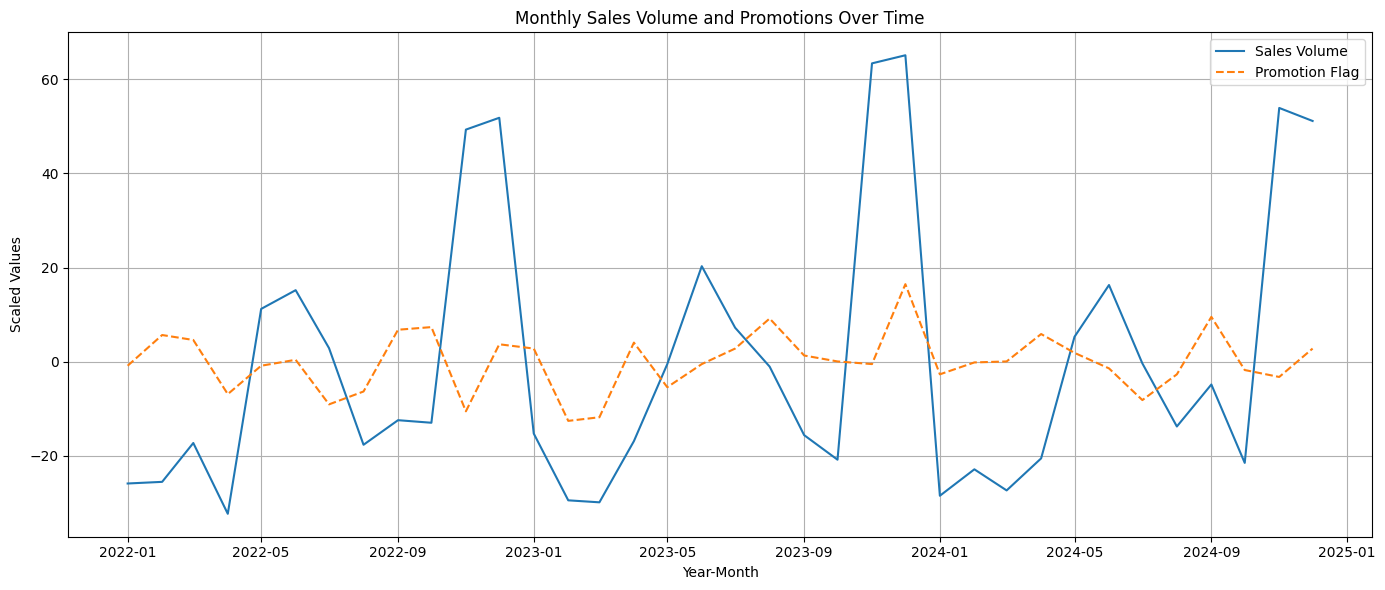

In [21]:
# Create the line plot
plt.figure(figsize=(14, 6))

sns.lineplot(sum_by_month_scaled, x='Year_Month', y='Sales_Volume_Scaled', label='Sales Volume', errorbar=None)
sns.lineplot(sum_by_month_scaled2, x='Year_Month', y='Promotion_Flag_Scaled', linestyle='--', label='Promotion Flag', errorbar=None)

plt.title('Monthly Sales Volume and Promotions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Scaled Values') 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

By comparing the two lines, it appears there is a positive correlation between promotions and sales. The plot suggests that an increase in promotional activity tends to be associated with an increase in sales volume. The large sales spikes likely result from a combination of seasonal demand and a corresponding increase in promotional efforts.

### Modeling


Fore modeling i will use ARIMA as baseline and SARIMA/SARIMAX as models to forecast demand.

In [22]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df.dropna(subset=['Date'])

# Set the index to the datetime for time series modeling
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# Corrected code for daily sales
df_daily_sales = df.groupby(df.index)[['Sales_Volume', 'Promotion_Flag']].sum()

# Convert the grouped index back to datetime for resampling
df_daily_sales.index = pd.to_datetime(df_daily_sales.index)

# Resample the daily sums to a monthly frequency
df_monthly_sales = df_daily_sales.resample('MS').sum()

training_df = df_monthly_sales[df_monthly_sales.index < '2024-01-01']
testing_df = df_monthly_sales[df_monthly_sales.index >= '2024-01-01']

training_df.index = training_df.index.to_period('M')
testing_df.index = testing_df.index.to_period('M')

X_train = training_df['Sales_Volume'] 
exog_var_train = training_df['Promotion_Flag']

y_test = testing_df['Sales_Volume'] 
exog_var_test = testing_df['Promotion_Flag']

In [23]:

# --- 1. ARIMA model (seasonal) ---
model = ARIMA(X_train, order=(1,1,1))
model_fit = model.fit()

# Forecast on testing data using get_forecast()
arima_manual_forecast = model_fit.get_forecast(steps=len(y_test)).predicted_mean
arima_manual_forecast.index = y_test.index

# --- 2. auto_arima model (seasonal) ---
auto_arima_model = auto_arima(
    X_train,
    seasonal=True,
    m=12,
    D=1,  # Set the seasonal differencing parameter
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)
auto_arima_forecast = auto_arima_model.predict(n_periods=len(y_test))
auto_arima_forecast_series = pd.Series(auto_arima_forecast, index=y_test.index)

# --- 3. SARIMAX model (seasonal) ---
sarimax_model = SARIMAX(
    X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit(disp=False)

# Forecast on testing data using get_forecast()
sarimax_forecast = sarimax_results.get_forecast(steps=len(y_test)).predicted_mean
sarimax_forecast.index = y_test.index

# --- 4. SARIMAX model (seasonal + exogenous variable) ---
sarimax_model_exgon = SARIMAX(
    X_train,
    exog=exog_var_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_exgon_results = sarimax_model_exgon.fit(disp=False)

# Forecast on testing data using get_forecast() with exogenous variables
sarimax_exgon_forecast = sarimax_exgon_results.get_forecast(steps=len(y_test), exog=exog_var_test).predicted_mean
sarimax_exgon_forecast.index = y_test.index

In [24]:
print("Model Forecast Comparison")
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Month': y_test.index,
    'Actual Sales Volume': y_test.values,
    'ARIMA Manual Forecast': arima_manual_forecast.values,
    'Auto ARIMA Forecast': auto_arima_forecast_series.values,
    'SARIMAX Forecast': sarimax_forecast.values,
    'SARIMAX EXGON Forecast': sarimax_exgon_forecast.values
})

# Calculate Errors
for col in ['ARIMA Manual Forecast', 'Auto ARIMA Forecast', 'SARIMAX Forecast', 'SARIMAX EXGON Forecast']:
    comparison_df[f'{col} Error %'] = (
        round((abs(comparison_df[col] - comparison_df['Actual Sales Volume']) / comparison_df['Actual Sales Volume'] * 100), 1)
    )

comparison_df

Model Forecast Comparison


,Month,Actual Sales Volume,ARIMA Manual Forecast,Auto ARIMA Forecast,SARIMAX Forecast,SARIMAX EXGON Forecast,ARIMA Manual Forecast Error %,Auto ARIMA Forecast Error %,SARIMAX Forecast Error %,SARIMAX EXGON Forecast Error %
0,2024-01,5737,7894.567515,6087.0,6161.737110,6034.782065,37.6,6.1,7.4,5.2
1,2024-02,5467,7703.512718,5083.0,5164.849539,5497.566281,40.9,7.0,5.5,0.6
2,2024-03,5767,7590.304722,5700.0,5781.667089,6090.606512,31.6,1.2,0.3,5.6
3,2024-04,5738,7523.224227,5835.0,5916.671769,5924.044535,31.1,1.7,3.1,3.2
4,2024-05,6632,7483.476215,6478.0,6559.671649,6741.377195,12.8,2.3,1.1,1.6
5,2024-06,6714,7459.923848,6820.0,6901.671652,6843.350781,11.1,1.6,2.8,1.9
6,2024-07,6482,7445.968080,6683.0,6764.671652,6462.941517,14.9,3.1,4.4,0.3
7,2024-08,6127,7437.698701,6464.0,6545.671652,6204.137136,21.4,5.5,6.8,1.3
8,2024-09,6154,7432.798747,5869.0,5950.671652,6148.278713,20.8,4.6,3.3,0.1
9,2024-10,5922,7429.895318,5940.0,6021.671652,5945.860855,25.5,0.3,1.7,0.4


In [25]:
print("Model Evaluation Metrics:")
metrics_data = {
    'Metric': ['MAE', 'RMSE', 'MAPE %'],
    'ARIMA Manual': [
        mean_absolute_error(y_test, arima_manual_forecast),
        root_mean_squared_error(y_test, arima_manual_forecast),
        mean_absolute_percentage_error(y_test, arima_manual_forecast) * 100
    ],
    'Auto ARIMA': [
        mean_absolute_error(y_test, auto_arima_forecast_series),
        root_mean_squared_error(y_test, auto_arima_forecast_series),
        mean_absolute_percentage_error(y_test, auto_arima_forecast_series) * 100
    ],
    'SARIMAX': [
        mean_absolute_error(y_test, sarimax_forecast),
        root_mean_squared_error(y_test, sarimax_forecast),
        mean_absolute_percentage_error(y_test, sarimax_forecast) * 100
    ],
    'SARIMAX_EXGON': [
        mean_absolute_error(y_test, sarimax_exgon_forecast),
        root_mean_squared_error(y_test, sarimax_exgon_forecast),
        mean_absolute_percentage_error(y_test, sarimax_exgon_forecast) * 100
    ]
}
metrics_df = pd.DataFrame(metrics_data)
for col in ['ARIMA Manual', 'Auto ARIMA', 'SARIMAX', 'SARIMAX_EXGON']:
    metrics_df[col] = metrics_df[col].map(lambda x: f"{x:,.2f}")
    
metrics_df

Model Evaluation Metrics:


,Metric,ARIMA Manual,Auto ARIMA,SARIMAX,SARIMAX_EXGON
0,MAE,"1,280.34",218.33,247.41,125.84
1,RMSE,"1,421.93",250.70,283.64,165.10
2,MAPE %,21.39,3.45,3.87,2.02


Based on the evaluation metrics, the SARIMAX_EXGON model is the most effective. It consistently outperformed all other models across every metric, most notably achieving the lowest RMSE of 165.10, a significant improvement over the standard SARIMAX model's RMSE of 283.64. This strong performance demonstrates that incorporating an exogenous variable (Promotion_Flag) added substantial predictive power to the model, allowing it to make more accurate forecasts. The table's data clearly supports the conclusion that external factors played a crucial role in predicting the sales volume.

#### Forecast Plots

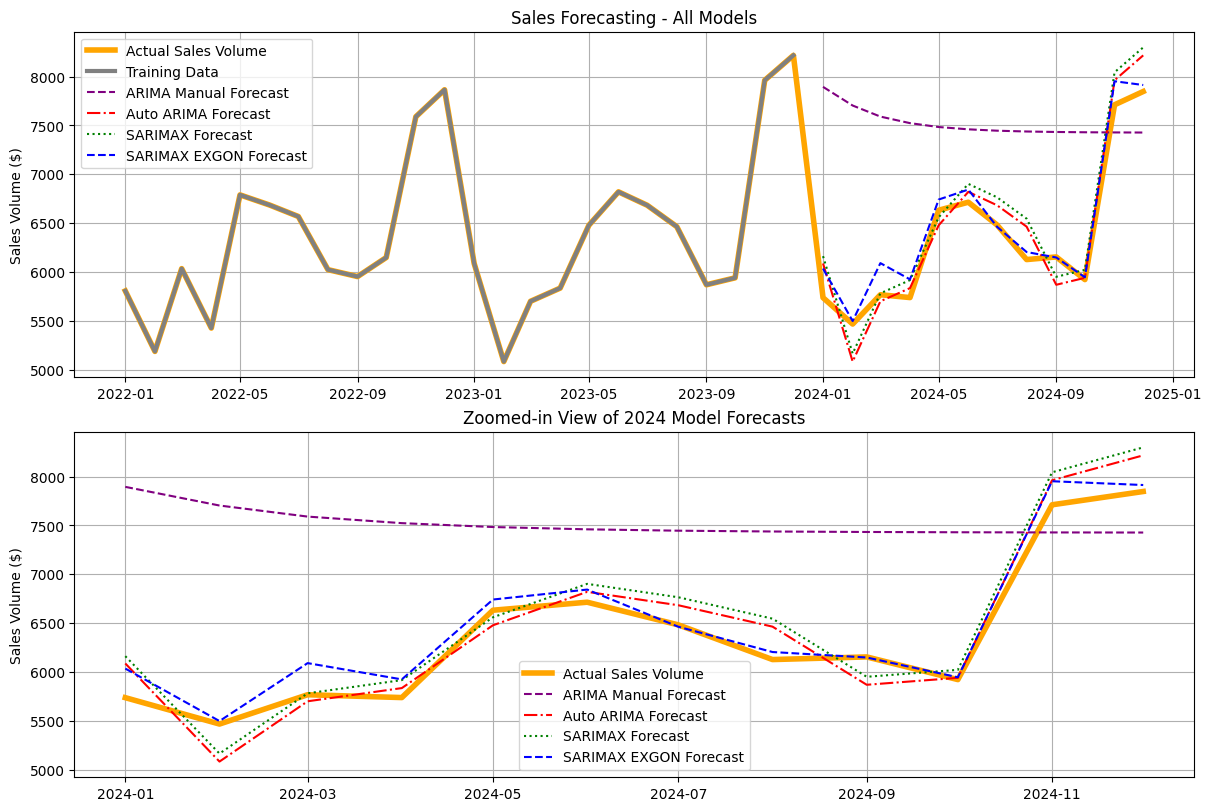

In [ ]:
# --- Plotting the results ---
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True, constrained_layout=True)


# Create a single series for the actual data
full_data = pd.concat([X_train, y_test])


# --- Top chart: yearly x-axis ---
axs[0].plot(full_data.index.to_timestamp(), full_data, label='Actual Sales Volume', color='orange', linewidth=4)
axs[0].plot(X_train.index.to_timestamp(), X_train, label='Training Data', color='grey', linewidth=3)
axs[0].plot(arima_manual_forecast.index.to_timestamp(), arima_manual_forecast, label='ARIMA Manual Forecast', color='purple', linestyle='--')
axs[0].plot(auto_arima_forecast_series.index.to_timestamp(), auto_arima_forecast_series, label='Auto ARIMA Forecast', color='red', linestyle='-.')
axs[0].plot(sarimax_forecast.index.to_timestamp(), sarimax_forecast, label='SARIMAX Forecast', color='green', linestyle=':')
axs[0].plot(sarimax_exgon_forecast.index.to_timestamp(), sarimax_exgon_forecast, label='SARIMAX EXGON Forecast', color='blue', linestyle='--')

axs[0].set_title('Sales Forecasting - All Models')
axs[0].set_ylabel('Sales Volume')
axs[0].legend()
axs[0].grid(True)

# --- Bottom chart: monthly x-axis (zoomed in) ---
axs[1].plot(y_test.index.to_timestamp(), y_test, label='Actual Sales Volume', color='orange', linewidth=4)
axs[1].plot(arima_manual_forecast.index.to_timestamp(), arima_manual_forecast, label='ARIMA Manual Forecast', color='purple', linestyle='--')
axs[1].plot(auto_arima_forecast_series.index.to_timestamp(), auto_arima_forecast_series, label='Auto ARIMA Forecast', color='red', linestyle='-.')
axs[1].plot(sarimax_forecast.index.to_timestamp(), sarimax_forecast, label='SARIMAX Forecast', color='green', linestyle=':')
axs[1].plot(sarimax_exgon_forecast.index.to_timestamp(), sarimax_exgon_forecast, label='SARIMAX EXGON Forecast', color='blue', linestyle='--')

axs[1].set_title('Zoomed-in View of 2024 Model Forecasts')
axs[1].set_ylabel('Sales Volume')
axs[1].legend()
axs[1].grid(True)

plt.show()

Based on the provided graph, the SARIMAX models are clearly the most accurate. Both the SARIMAX Forecast and SARIMAX EXGON Forecast lines closely track the actual sales data, successfully capturing the sharp seasonal fluctuations and overall trend. This strong performance indicates that these models correctly identified the seasonal and external factors influencing sales. In contrast, the Auto ARIMA Forecast performs reasonably well but shows slightly larger deviations from the actual values. The least effective model is the ARIMA Manual Forecast, which fails to account for seasonality, resulting in a flat projection and significant errors throughout the forecast period. The visual evidence strongly supports the conclusion that the inclusion of seasonal and exogenous variables is critical for accurate forecasting with this dataset.

### Summary

In summary, the SARIMAX and Auto ARIMA models successfully identified and captured the seasonal patterns inherent in the product sales data. This is evident from their forecasts, which accurately tracked the cyclical ups and downs of the actual sales volume.

In contrast, the ARIMA Manual model, which lacked a seasonal component, failed to recognize these patterns and instead produced a flat, inaccurate forecast. This demonstrates that for this particular dataset, accounting for seasonality was the single most crucial factor for achieving a reliable and accurate forecast. The strong performance of the SARIMAX models further highlights the benefit of incorporating both seasonal and exogenous variables to enhance predictive power.